In [1]:
dir0 =  '/home/cloudera/2.kkbox_churn/data01/big_table_01/'
infile = dir0 + '19a.train_set'

In [2]:
df0 = spark.read.format('parquet').load(infile)
df0.count()

570896

In [29]:
# count null values

from pyspark.sql.functions import col

for c in df0.columns:
    cnt_na = df0.where(col(c).isNull()).count()
    print(c, ':', cnt_na)

msno : 0
city : 0
age : 294579
gender : 292758
registered_via : 0
days_since_init_regist : 0
init_date : 0
final_date : 0
gaps_count : 0
total_gap_len : 0
has_long_gap : 0
has_expired : 0
last_pay_method : 0
last_plan_days : 0
last_list_price : 0
last_actual_paid : 0
last_discount : 0
last_paid_per_day : 0
actual_paid_cnt_uniq : 0
actual_paid_mode : 0
auto_renew_cnt_uniq : 0
auto_renew_mode : 0
discount_cnt_uniq : 0
discount_mode : 0
list_price_cnt_uniq : 0
list_price_mode : 0
pay_method_cnt_uniq : 0
pay_method_mode : 0
plan_days_cnt_uniq : 0
plan_days_mode : 0
actual_paid_sum : 0
actual_paid_per_sub_day : 0
discount_sum : 0
discount_per_sub_day : 0
list_price_sum : 0
list_price_per_sub_day : 0
last12WeekOnLine : 0
w12_M25 : 0
w12_M50 : 0
w12_M75 : 0
w12_M985 : 0
w12_M100 : 0
w12_Munq : 0
w12_Msecs : 0
w12_Mtotal : 0
w12_M25_D_Mtotal : 231
w12_M50_D_Mtotal : 231
w12_M75_D_Mtotal : 231
w12_M985_D_Mtotal : 231
w12_M100_D_Mtotal : 231
w12_Munq_D_Mtotal : 231
w12_M25M50M75_D_Mtotal : 231
w

# find numeric/categorical fields

In [3]:
field_types = df0.dtypes
field_types

[('msno', 'string'),
 ('city', 'string'),
 ('age', 'int'),
 ('gender', 'string'),
 ('registered_via', 'string'),
 ('days_since_init_regist', 'int'),
 ('init_date', 'string'),
 ('final_date', 'string'),
 ('gaps_count', 'int'),
 ('total_gap_len', 'int'),
 ('has_long_gap', 'boolean'),
 ('has_expired', 'boolean'),
 ('last_pay_method', 'string'),
 ('last_plan_days', 'int'),
 ('last_list_price', 'int'),
 ('last_actual_paid', 'int'),
 ('last_discount', 'int'),
 ('last_paid_per_day', 'double'),
 ('actual_paid_cnt_uniq', 'int'),
 ('actual_paid_mode', 'int'),
 ('auto_renew_cnt_uniq', 'int'),
 ('auto_renew_mode', 'boolean'),
 ('discount_cnt_uniq', 'int'),
 ('discount_mode', 'int'),
 ('list_price_cnt_uniq', 'int'),
 ('list_price_mode', 'int'),
 ('pay_method_cnt_uniq', 'int'),
 ('pay_method_mode', 'string'),
 ('plan_days_cnt_uniq', 'int'),
 ('plan_days_mode', 'int'),
 ('actual_paid_sum', 'int'),
 ('actual_paid_per_sub_day', 'double'),
 ('discount_sum', 'int'),
 ('discount_per_sub_day', 'double'),
 

In [4]:
numeric_cols = [field_type[0]  for field_type in field_types  if field_type[1] in ['int', 'double']]
categ_cols =  [field_type[0]  for field_type in field_types  if field_type[1] in ['string', 'boolean']]

# check:
len(df0.columns) == len(numeric_cols) + len(categ_cols)  # should be true

True

In [25]:
numeric_cols

['age',
 'days_since_init_regist',
 'gaps_count',
 'total_gap_len',
 'last_plan_days',
 'last_list_price',
 'last_actual_paid',
 'last_discount',
 'last_paid_per_day',
 'actual_paid_cnt_uniq',
 'actual_paid_mode',
 'auto_renew_cnt_uniq',
 'discount_cnt_uniq',
 'discount_mode',
 'list_price_cnt_uniq',
 'list_price_mode',
 'pay_method_cnt_uniq',
 'plan_days_cnt_uniq',
 'plan_days_mode',
 'actual_paid_sum',
 'actual_paid_per_sub_day',
 'discount_sum',
 'discount_per_sub_day',
 'list_price_sum',
 'list_price_per_sub_day',
 'last12WeekOnLine',
 'w12_M25',
 'w12_M50',
 'w12_M75',
 'w12_M985',
 'w12_M100',
 'w12_Munq',
 'w12_Msecs',
 'w12_Mtotal',
 'w12_M25_D_Mtotal',
 'w12_M50_D_Mtotal',
 'w12_M75_D_Mtotal',
 'w12_M985_D_Mtotal',
 'w12_M100_D_Mtotal',
 'w12_Munq_D_Mtotal',
 'w12_M25M50M75_D_Mtotal',
 'w12_M985M100_D_Mtotal',
 'w12_M25M50_D_Mtotal',
 'w12_M25_D_M50M75M985M100',
 'w12_M25M50_D_M75M985M100',
 'w12_M25M50M75_D_M985M100',
 'w12_M25M50M75M985_D_M100',
 'last9WeekOnLine',
 'w9_M25'

# ignore some fields

In [5]:
cols_to_ignore = ['age'] \
    + [temp.format(ww) 
           for ww in ['1','2','4','6','9','12']
           for temp in ['w{}_M25_D_M50M75M985M100', 'w{}_M25M50_D_M75M985M100',
                        'w{}_M25M50M75_D_M985M100', 'w{}_M25M50M75M985_D_M100']
      ]

In [6]:
cols_select = set(numeric_cols) - set(cols_to_ignore)

# divide fields into groups

In [7]:
# divide `cols_select` into groups

import re

col_groups = [[] for i in range(7)]
ind = {ww[1]:(ww[0]+1)  for ww in enumerate(['1','2','4','6','9','12'])}
for c in cols_select:
    ww = None
    m1 = re.match('w(\d+)_M', c)
    if m1:
        ww = m1.groups()[0]
    else:    
        m2 = re.match('last(\d+)WeekOnLine', c)
        if m2:
            ww = m2.groups()[0]
            
    if ww:
        col_groups[ind[ww]].append(c)
    else:
         col_groups[0].append(c)

In [65]:
col_groups

[['days_since_init_regist',
  'plan_days_cnt_uniq',
  'list_price_per_sub_day',
  'auto_renew_cnt_uniq',
  'total_gap_len',
  'discount_per_sub_day',
  'discount_mode',
  'list_price_mode',
  'actual_paid_cnt_uniq',
  'last_plan_days',
  'list_price_sum',
  'discount_cnt_uniq',
  'last_paid_per_day',
  'last_actual_paid',
  'last_discount',
  'pay_method_cnt_uniq',
  'plan_days_mode',
  'gaps_count',
  'actual_paid_sum',
  'list_price_cnt_uniq',
  'last_list_price',
  'discount_sum',
  'actual_paid_mode',
  'actual_paid_per_sub_day'],
 ['w1_M50_D_Mtotal',
  'w1_Mtotal',
  'w1_M75_D_Mtotal',
  'w1_Msecs',
  'w1_M25_D_Mtotal',
  'w1_M50',
  'last1WeekOnLine',
  'w1_M100',
  'w1_M985_D_Mtotal',
  'w1_M100_D_Mtotal',
  'w1_M985',
  'w1_Munq',
  'w1_M25',
  'w1_M25M50M75_D_Mtotal',
  'w1_M985M100_D_Mtotal',
  'w1_M75',
  'w1_Munq_D_Mtotal',
  'w1_M25M50_D_Mtotal'],
 ['w2_M985_D_Mtotal',
  'last2WeekOnLine',
  'w2_Munq',
  'w2_Mtotal',
  'w2_M985',
  'w2_M75_D_Mtotal',
  'w2_M100_D_Mtotal',


# field selection groupwise

In [15]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns

def get_corr_matrix(df, columns):
    '''Return a 2D NumPy array'''
    va = VectorAssembler().setInputCols(columns).setOutputCol('features')
    df1 = va.transform(df).select('features')
    corr_matrix = Correlation.corr(df1, 'features').collect()[0][0].toArray()  # a NumPy 2D array
    return corr_matrix

def plot_correlation_heatmap(corr_matrix, column_names, ax):
    sns.heatmap(corr_matrix, ax=ax, center=0.0, vmin=-1, vmax=1,
                xticklabels=column_names, yticklabels=column_names, linewidth=0.5)

In [69]:
def find_correlated_index_groups(correlated_pairs):        
    result_prev = correlated_pairs
    result = []
    while True:
        for p in result_prev:
            # add `p` to `result`
            added = False
            for i in range(len(result)):
                if p.intersection(result[i]):
                    result[i] = result[i].union(p)
                    added = True
                    break
            if not added:
                result.append(p)

        # check whether the elements of `result` are mutually disjoint        
        disjoint = True
        for i in range(len(result)):
            for j in range(i+1, len(result)):
                if result[i].intersection(result[j]):
                    disjoint = False
                    break;
            if not disjoint:
                break;
        #
        if disjoint:
            break
        else:
            result_prev = result
            result = []
    # end of while        
    
    return result

In [80]:
def find_correlated_field_groups(corr_mat, field_names, corr_abs_threshold):
    assert corr_mat.shape[0] == len(field_names)
    
    correlated_pairs = []
    for i in range(corr_mat.shape[0]):
        for j in range(i):    
            if abs(corr_mat[i,j]) >= corr_abs_threshold:
                correlated_pairs.append({i, j})
                
    corr_index_groups = find_correlated_index_groups(correlated_pairs)
    
    corr_field_groups = []
    for g in corr_index_groups:
        fields = {field_names[i]  for i in g}
        corr_field_groups.append(fields)

    # add isolated (uncorrelated to others) fields
    all_ind = set(range(corr_mat.shape[0]))
    for g in corr_index_groups:
        all_ind = all_ind - g
        
    for i in all_ind:
        corr_field_groups.append({field_names[i]})
        
    #    
    return corr_field_groups

## group 0

In [143]:
# set threshold:
corr_abs_threshold = 0.7

In [144]:
corr_mat = get_corr_matrix(df0, col_groups[0])
find_correlated_field_groups(corr_mat, col_groups[0], corr_abs_threshold)

[{'actual_paid_mode',
  'actual_paid_sum',
  'last_actual_paid',
  'last_list_price',
  'last_plan_days',
  'list_price_mode',
  'list_price_sum',
  'plan_days_mode'},
 {'discount_cnt_uniq',
  'discount_mode',
  'discount_per_sub_day',
  'discount_sum'},
 {'actual_paid_per_sub_day', 'last_paid_per_day', 'list_price_per_sub_day'},
 {'actual_paid_cnt_uniq', 'list_price_cnt_uniq', 'pay_method_cnt_uniq'},
 {'gaps_count', 'total_gap_len'},
 {'days_since_init_regist'},
 {'plan_days_cnt_uniq'},
 {'auto_renew_cnt_uniq'},
 {'last_discount'}]

In [161]:
# add field here:
fields_select_within_g0 = [
    'plan_days_mode',
    'discount_mode',
    'last_paid_per_day',
    'actual_paid_cnt_uniq',
    'gaps_count',
    'days_since_init_regist',
    'plan_days_cnt_uniq',
    'auto_renew_cnt_uniq',
    'last_discount'
]

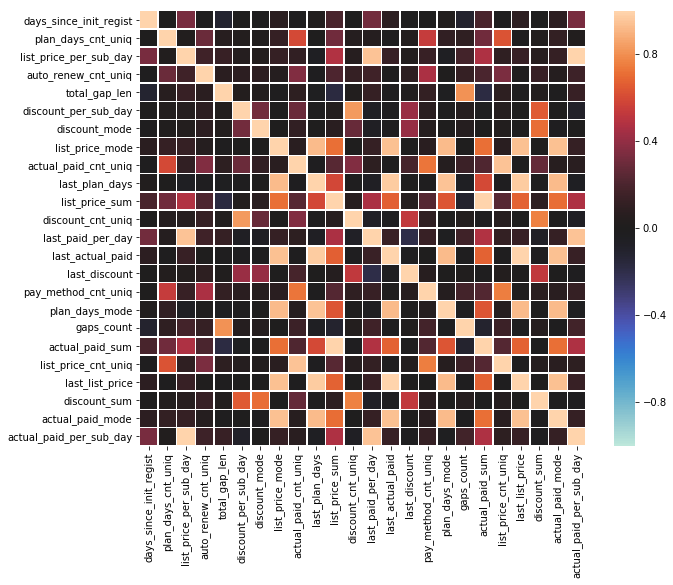

In [18]:
# plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plot_correlation_heatmap(corr_mat, col_groups[0], ax)
fig.set_size_inches(10,8)
plt.show()

## group 1 ~ 6

In [146]:
g = 1
ww = '1'

df = df0.where('w'+ww+'_Mtotal > 0')
corr_mat = get_corr_matrix(df, col_groups[g])
find_correlated_field_groups(corr_mat, col_groups[g], corr_abs_threshold)

[{'w1_M100', 'w1_Msecs', 'w1_Mtotal', 'w1_Munq'},
 {'w1_M100_D_Mtotal',
  'w1_M25M50M75_D_Mtotal',
  'w1_M25M50_D_Mtotal',
  'w1_M25_D_Mtotal',
  'w1_M985M100_D_Mtotal'},
 {'w1_M50_D_Mtotal'},
 {'w1_M75_D_Mtotal'},
 {'w1_M50'},
 {'last1WeekOnLine'},
 {'w1_M985_D_Mtotal'},
 {'w1_M985'},
 {'w1_M25'},
 {'w1_M75'},
 {'w1_Munq_D_Mtotal'}]

In [147]:
# add field here:
fields_select_within_g1 = [
    'w1_Mtotal',
    'w1_M100_D_Mtotal',
    'w1_M50_D_Mtotal',
    'w1_M75_D_Mtotal',
    'w1_M50',
    'last1WeekOnLine',
    'w1_M985_D_Mtotal',
    'w1_M985',
    'w1_M25',
    'w1_M75',
    'w1_Munq_D_Mtotal'
]

In [148]:
g = 2
ww = '2'

df = df0.where('w'+ww+'_Mtotal > 0')
corr_mat = get_corr_matrix(df, col_groups[g])
find_correlated_field_groups(corr_mat, col_groups[g], corr_abs_threshold)

[{'w2_M100', 'w2_Msecs', 'w2_Mtotal', 'w2_Munq'},
 {'w2_M100_D_Mtotal',
  'w2_M25M50M75_D_Mtotal',
  'w2_M25M50_D_Mtotal',
  'w2_M25_D_Mtotal',
  'w2_M985M100_D_Mtotal'},
 {'w2_M985_D_Mtotal'},
 {'last2WeekOnLine'},
 {'w2_M985'},
 {'w2_M75_D_Mtotal'},
 {'w2_M75'},
 {'w2_M50'},
 {'w2_M25'},
 {'w2_M50_D_Mtotal'},
 {'w2_Munq_D_Mtotal'}]

In [151]:
# add field here:
fields_select_within_g2 = [
    'w2_Mtotal', 
    'w2_M100_D_Mtotal',
    'w2_M985_D_Mtotal',
    'last2WeekOnLine',
    'w2_M985',
    'w2_M75_D_Mtotal',
    'w2_M75',
    'w2_M50',
    'w2_M25',
    'w2_M50_D_Mtotal',
    'w2_Munq_D_Mtotal'
]

In [149]:
g = 3
ww = '4'

df = df0.where('w'+ww+'_Mtotal > 0')
corr_mat = get_corr_matrix(df, col_groups[g])
find_correlated_field_groups(corr_mat, col_groups[g], corr_abs_threshold)

[{'w4_M100', 'w4_Msecs', 'w4_Mtotal', 'w4_Munq'},
 {'w4_M100_D_Mtotal',
  'w4_M25M50M75_D_Mtotal',
  'w4_M25M50_D_Mtotal',
  'w4_M25_D_Mtotal',
  'w4_M985M100_D_Mtotal'},
 {'w4_M50_D_Mtotal'},
 {'w4_Munq_D_Mtotal'},
 {'w4_M50'},
 {'w4_M985_D_Mtotal'},
 {'w4_M75'},
 {'w4_M985'},
 {'w4_M25'},
 {'w4_M75_D_Mtotal'},
 {'last4WeekOnLine'}]

In [150]:
# add field here:
userlog_fields = [
    'w4_Mtotal',
    'w4_M100_D_Mtotal',
    'w4_M50_D_Mtotal',
    'w4_Munq_D_Mtotal',
    'w4_M50',
    'w4_M985_D_Mtotal',
    'w4_M75',
    'w4_M985',
    'w4_M25',
    'w4_M75_D_Mtotal',
    'last4WeekOnLine']
fields_select_within_g3 = [f.format(4)  for f in userlog_fields]

In [152]:
g = 4
ww = '6'

df = df0.where('w'+ww+'_Mtotal > 0')
corr_mat = get_corr_matrix(df, col_groups[g])
find_correlated_field_groups(corr_mat, col_groups[g], corr_abs_threshold)

[{'w6_M100_D_Mtotal',
  'w6_M25M50M75_D_Mtotal',
  'w6_M25M50_D_Mtotal',
  'w6_M25_D_Mtotal',
  'w6_M985M100_D_Mtotal'},
 {'w6_M100', 'w6_Msecs', 'w6_Mtotal', 'w6_Munq'},
 {'w6_M50', 'w6_M75'},
 {'w6_Munq_D_Mtotal'},
 {'w6_M985'},
 {'w6_M75_D_Mtotal'},
 {'w6_M25'},
 {'w6_M50_D_Mtotal'},
 {'last6WeekOnLine'},
 {'w6_M985_D_Mtotal'}]

In [153]:
# add field here:
fields_select_within_g4 = [
    'w6_M100_D_Mtotal',
    'w6_Mtotal',
    'w6_M50', 
    'w6_Munq_D_Mtotal',
    'w6_M985',
    'w6_M75_D_Mtotal',
    'w6_M25',
    'w6_M50_D_Mtotal',
    'last6WeekOnLine',
    'w6_M985_D_Mtotal']

In [154]:
g = 5
ww = '9'

df = df0.where('w'+ww+'_Mtotal > 0')
corr_mat = get_corr_matrix(df, col_groups[g])
find_correlated_field_groups(corr_mat, col_groups[g], corr_abs_threshold)

[{'w9_M100', 'w9_Msecs', 'w9_Mtotal', 'w9_Munq'},
 {'w9_M100_D_Mtotal',
  'w9_M25M50M75_D_Mtotal',
  'w9_M25M50_D_Mtotal',
  'w9_M25_D_Mtotal',
  'w9_M985M100_D_Mtotal'},
 {'w9_M50', 'w9_M75'},
 {'last9WeekOnLine'},
 {'w9_M985_D_Mtotal'},
 {'w9_M25'},
 {'w9_Munq_D_Mtotal'},
 {'w9_M75_D_Mtotal'},
 {'w9_M50_D_Mtotal'},
 {'w9_M985'}]

In [155]:
# add field here:
fields_select_within_g5 = [
    'w9_Mtotal',
    'w9_M100_D_Mtotal',
    'w9_M50', 
    'last9WeekOnLine',
    'w9_M985_D_Mtotal',
    'w9_M25',
    'w9_Munq_D_Mtotal',
    'w9_M75_D_Mtotal',
    'w9_M50_D_Mtotal',
    'w9_M985']


In [156]:
g = 6
ww = '12'

df = df0.where('w'+ww+'_Mtotal > 0')
corr_mat = get_corr_matrix(df, col_groups[g])
find_correlated_field_groups(corr_mat, col_groups[g], corr_abs_threshold)

[{'w12_M100', 'w12_Msecs', 'w12_Mtotal', 'w12_Munq'},
 {'w12_M100_D_Mtotal',
  'w12_M25M50M75_D_Mtotal',
  'w12_M25M50_D_Mtotal',
  'w12_M25_D_Mtotal',
  'w12_M985M100_D_Mtotal'},
 {'w12_M50', 'w12_M75'},
 {'w12_M75_D_Mtotal'},
 {'w12_M50_D_Mtotal'},
 {'w12_M25'},
 {'w12_Munq_D_Mtotal'},
 {'w12_M985_D_Mtotal'},
 {'last12WeekOnLine'},
 {'w12_M985'}]

In [157]:
# add field here:
fields_select_within_g6 = [
    'w12_Mtotal',
    'w12_M100_D_Mtotal',
    'w12_M50', 
    'w12_M75_D_Mtotal',
    'w12_M50_D_Mtotal',
    'w12_M25',
    'w12_Munq_D_Mtotal',
    'w12_M985_D_Mtotal',
    'last12WeekOnLine',
    'w12_M985']


# final field-selection

In [162]:
field_groups = [
    fields_select_within_g0, 
    fields_select_within_g1, 
    fields_select_within_g2, 
    fields_select_within_g3, 
    fields_select_within_g4, 
    fields_select_within_g5, 
    fields_select_within_g6
]

In [163]:
field_groups

[['plan_days_mode',
  'discount_mode',
  'last_paid_per_day',
  'actual_paid_cnt_uniq',
  'gaps_count',
  'days_since_init_regist',
  'plan_days_cnt_uniq',
  'auto_renew_cnt_uniq',
  'last_discount'],
 ['w1_Mtotal',
  'w1_M100_D_Mtotal',
  'w1_M50_D_Mtotal',
  'w1_M75_D_Mtotal',
  'w1_M50',
  'last1WeekOnLine',
  'w1_M985_D_Mtotal',
  'w1_M985',
  'w1_M25',
  'w1_M75',
  'w1_Munq_D_Mtotal'],
 ['w2_Mtotal',
  'w2_M100_D_Mtotal',
  'w2_M985_D_Mtotal',
  'last2WeekOnLine',
  'w2_M985',
  'w2_M75_D_Mtotal',
  'w2_M75',
  'w2_M50',
  'w2_M25',
  'w2_M50_D_Mtotal',
  'w2_Munq_D_Mtotal'],
 ['w4_Mtotal',
  'w4_M100_D_Mtotal',
  'w4_M50_D_Mtotal',
  'w4_Munq_D_Mtotal',
  'w4_M50',
  'w4_M985_D_Mtotal',
  'w4_M75',
  'w4_M985',
  'w4_M25',
  'w4_M75_D_Mtotal',
  'last4WeekOnLine'],
 ['w6_M100_D_Mtotal',
  'w6_M100',
  'w6_M50',
  'w6_M75',
  'w6_Munq_D_Mtotal',
  'w6_M985',
  'w6_M75_D_Mtotal',
  'w6_M25',
  'w6_M50_D_Mtotal',
  'last6WeekOnLine',
  'w6_M985_D_Mtotal'],
 ['w9_Mtotal',
  'w9_M100

## wXX_Mtotal > 0

In [164]:
df = df0.where('w1_Mtotal > 0').where('w2_Mtotal > 0').where('w4_Mtotal > 0') \
    .where('w6_Mtotal > 0').where('w9_Mtotal > 0').where('w12_Mtotal > 0')
cols = [c  for g in field_groups[:7]  for c in g]

corr_mat = get_corr_matrix(df, cols)
find_correlated_field_groups(corr_mat, cols, corr_abs_threshold)

[{'w12_Mtotal', 'w1_Mtotal', 'w2_Mtotal', 'w4_Mtotal', 'w6_M100', 'w9_Mtotal'},
 {'w12_M100_D_Mtotal',
  'w1_M100_D_Mtotal',
  'w2_M100_D_Mtotal',
  'w4_M100_D_Mtotal',
  'w6_M100_D_Mtotal',
  'w9_M100_D_Mtotal'},
 {'last12WeekOnLine',
  'last1WeekOnLine',
  'last2WeekOnLine',
  'last4WeekOnLine',
  'last6WeekOnLine',
  'last9WeekOnLine'},
 {'w12_M985', 'w1_M985', 'w2_M985', 'w4_M985', 'w6_M985', 'w9_M985'},
 {'w12_M50',
  'w1_M50',
  'w1_M75',
  'w2_M50',
  'w2_M75',
  'w4_M50',
  'w4_M75',
  'w6_M50',
  'w6_M75',
  'w9_M50'},
 {'w12_M25', 'w1_M25', 'w2_M25', 'w4_M25', 'w6_M25', 'w9_M25'},
 {'w12_Munq_D_Mtotal',
  'w1_Munq_D_Mtotal',
  'w2_Munq_D_Mtotal',
  'w4_Munq_D_Mtotal',
  'w6_Munq_D_Mtotal',
  'w9_Munq_D_Mtotal'},
 {'w12_M50_D_Mtotal',
  'w2_M50_D_Mtotal',
  'w4_M50_D_Mtotal',
  'w6_M50_D_Mtotal',
  'w9_M50_D_Mtotal'},
 {'w12_M985_D_Mtotal',
  'w2_M985_D_Mtotal',
  'w4_M985_D_Mtotal',
  'w6_M985_D_Mtotal',
  'w9_M985_D_Mtotal'},
 {'w12_M75_D_Mtotal', 'w6_M75_D_Mtotal', 'w9_M75_

In [170]:
# selected fields:
fields_selected = [
    'w4_Mtotal',
    'w4_M100_D_Mtotal',
    'last4WeekOnLine',
    'w4_M985',
    'w4_M50',
    'w4_M25', 
    'w4_Munq_D_Mtotal',
    'w4_M50_D_Mtotal',
    'w4_M985_D_Mtotal',
    'w6_M75_D_Mtotal',
    'plan_days_mode',
    'discount_mode',
    'last_paid_per_day',
    'actual_paid_cnt_uniq',
    'gaps_count',
    'days_since_init_regist',
    'plan_days_cnt_uniq',
    'auto_renew_cnt_uniq',
    'last_discount',
    'w1_M50_D_Mtotal',
    'w1_M75_D_Mtotal',
    'w1_M985_D_Mtotal',
    'w2_M75_D_Mtotal',
    'w4_M75_D_Mtotal'
]

len(fields_selected)

24

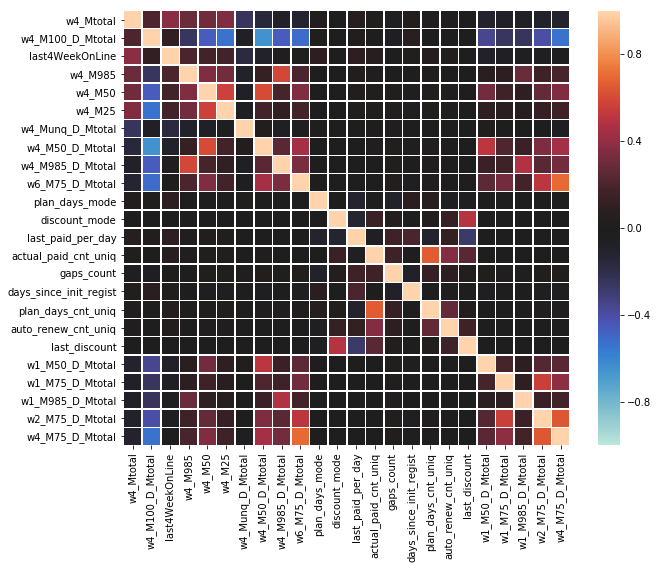

In [167]:
import matplotlib.pyplot as plt

corr_mat = get_corr_matrix(df, fields_selected)

fig, ax = plt.subplots()
plot_correlation_heatmap(corr_mat, fields_selected, ax)
fig.set_size_inches(10,8)
plt.show()

# corr. matrix of final selected fields:

In [173]:
# output
df = df0.select(categ_cols+fields_selected)

outfile = dir0 + '20a.train.field-select_correlation-0.7'
df.write.format('parquet').save(outfile)